In [8]:
!pip3 install -U scikit-learn
!pip3 install torch torchvision torchaudio
!pip3 install pickle
!pip3 install -U varname

^C

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


  Using cached varname-0.11.0-py3-none-any.whl (23 kB)
  Using cached executing-1.2.0-py2.py3-none-any.whl (24 kB)
['d:\\mycode\\BSc\\python', 'd:\\simon\\Anaconda\\python39.zip', 'd:\\simon\\Anaconda\\DLLs', 'd:\\simon\\Anaconda\\lib', 'd:\\simon\\Anaconda', '', 'd:\\simon\\Anaconda\\lib\\site-packages', 'd:\\simon\\Anaconda\\lib\\site-packages\\locket-0.2.1-py3.9.egg', 'd:\\simon\\Anaconda\\lib\\site-packages\\win32', 'd:\\simon\\Anaconda\\lib\\site-packages\\win32\\lib', 'd:\\simon\\Anaconda\\lib\\site-packages\\Pythonwin', 'd:\\simon\\Anaconda\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\simon\\.ipython', 'C:\\Python311\\Lib\\site-packages', 'C:\\Python311\\Lib\\site-packages']


In [246]:
import pandas as pd 
import numpy as np
import math 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
from scipy.linalg import sqrtm

import pickle 

Unpacking the data

In [2]:
with open('data/sampled_filters_train.pkl', 'rb') as f:
    data = pickle.load(f)

In [175]:
def get_data(data):
    #in data
    #wavelength (4000000, 149)
    #spectra (4000000, 149)
    #X (4000000, 37)
    #y (4000000, 4)
    #z (4000000, 1)
    #zmin (float)
    #zmax (float)
    #filter_names (string list), len = 37
    df_X = pd.DataFrame(data['X'])
    outlier_columns = df_X.columns[df_X.gt(58.8).any(axis = 0)]
    df_X = df_X.drop(outlier_columns, axis = 1)
    X = df_X.to_numpy()
    y = pd.DataFrame(data['y'])
    z = pd.DataFrame(data['z'])
    wavelengths = data['wavelengths']
    spectra = data['spectra']
    
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(df_X)
    y_normalized = scaler.fit_transform(y)

    names=data['filter_names']
    filter_wls = [int(name[1:-1].rstrip('W')) for name in names]
    filter_wls = [element for i, element in enumerate(filter_wls) if i not in outlier_columns]
    indices=[0,10,30,500,15000,800000]
    return filter_wls, wavelengths, spectra, X, X_normalized, y, y_normalized, z
filter_wls, wavelengths, spectra, X, X_normalized, y, y_normalized, z = get_data(data)


In [4]:
np.array(filter_wls)

array([  70,   90,  115,  140,  150,  162,  182,  187,  200,  210,  212,
        250,  277,  300,  322,  335,  356,  360,  405,  410,  430,  444,
        460,  480,  560,  770, 1000, 1130, 1280, 1500, 1800])

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


define network

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

class SingleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SingleConv, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose1d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff = x2.size()[2] - x1.size()[2]
        x1 = F.pad(x1, (diff // 2, (diff + 1) // 2))
        x = torch.cat([x2, x1], dim=1)

        x = self.conv(x)
        return x

class BigUNet(nn.Module):
    def __init__(self):
        super(BigUNet, self).__init__()
        self.conv = DoubleConv(1, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.convOut = nn.Conv1d(64, 1, kernel_size = 1)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x3 = self.up2(x4, x3)
        x2 = self.up3(x3, x2)
        x1 = self.up4(x2, x1)
        x = self.convOut(x1)
        return x
    
class MedBigUNet(nn.Module):
    def __init__(self):
        super(MedBigUNet, self).__init__()
        self.conv = DoubleConv(1, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.up2 = Up(256, 128)
        self.up3 = Up(128, 64)
        self.up4 = Up(64, 32)
        self.convOut = nn.Conv1d(32, 1, kernel_size = 1)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x3 = self.up2(x4, x3)
        x2 = self.up3(x3, x2)
        x1 = self.up4(x2, x1)
        x = self.convOut(x1)
        return x

class MediumUNet(nn.Module):
    def __init__(self):
        super(MediumUNet, self).__init__()
        self.conv = DoubleConv(1, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.up1 = Up(256, 128)
        self.up2 = Up(128, 64)
        self.convOut = nn.Conv1d(64, 1, kernel_size = 1)
        
    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x2 = self.up1(x3, x2)
        x1 = self.up2(x2, x1)
        x = self.convOut(x1)
        return x

class SmallUNet(nn.Module):
    def __init__(self):
        super(SmallUNet, self).__init__()
        self.conv = DoubleConv(1, 32)
        self.down1 = DoubleConv(32, 64)
        self.down2 = DoubleConv(64, 128)
        self.up1 = Up(128, 64)
        self.up2 = Up(64, 32)
        self.convOut = nn.Conv1d(32, 1, kernel_size = 1)
        
    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x2 = self.up1(x3, x2)
        x1 = self.up2(x2, x1)
        x = self.convOut(x1)
        return x


Add Noise

In [116]:
def cos_betaAlpha_schedule(T = 300, s=0.005):
    x = torch.linspace(0, T, T+1)
    alphas_cumprod = torch.cos(((x / T) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    betas = torch.clip(betas, 0.0001, 0.9999)
    alpha_bar = np.cumprod(np.array([1-betas[i] for i in range(len(betas))]))
    return betas, alpha_bar

def add_noise1(X, t, beta_t, alpha_bar):
    if t == 0:
        X_tm1 = X.numpy()
    else:
        mu, sigma = math.sqrt(alpha_bar[t - 1]) * X, (1 - alpha_bar[t - 1]) * np.identity(len(X))
        X_tm1 = np.random.multivariate_normal(mu, sigma)
    mu, sigma = math.sqrt(1 - beta_t[t]) * X_tm1, (beta_t[t]) * np.identity(len(X_tm1))
    X_t = np.random.multivariate_normal(mu, sigma)
    pred_noise =  X_t - X_tm1
    return X_t, pred_noise

def add_noise(X, t, alpha_bar):
    X = X.clone().detach()
    eps = torch.randn_like(X)
    mean = math.sqrt(alpha_bar[t - 1]) * X
    std = math.sqrt(1 - alpha_bar[t - 1])
    sample = mean + std * eps
    return sample, eps

def gen_dataset(data, T = 300):
    X_t_arr = []
    X_noise_arr = []

    beta_t, alpha_bar = cos_betaAlpha_schedule(T = T)

    for d in data:
        t = np.random.randint(1, T + 1)
        X_t, X_noise = add_noise(d, t, alpha_bar)
        X_t_arr.append(X_t.tolist())
        X_noise_arr.append(X_noise.tolist())

    return X_t_arr, X_noise_arr

def denoise(model, X, T = 300):
    betas, alpha_bar = cos_betaAlpha_schedule()

    X = torch.tensor(X)
    X_noise = torch.zeros(len(X))
    for t in range(T-1, -1, -1):
        mu_t = (1 / math.sqrt(1 - betas[t])) * (X - (betas[t])/(math.sqrt(1 - alpha_bar[t])) * X_noise)
        X = torch.tensor(np.random.multivariate_normal(mu_t, betas[T - 1] * np.identity(31)))

        X_noise = model(X.unsqueeze(0).unsqueeze(0).to(device))
        X = X - X_noise
    return X

class MyDataset(Dataset):
    def __init__(self, data_dict):
        self.data_dict = data_dict
        self.keys = list(data_dict.keys())
        self.length = len(data_dict[self.keys[0]])
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        data = {key: self.data_dict[key][index] for key in self.keys}
        return data


Training

In [117]:
def train_model(model, n = len(X_normalized), batch_size = 256, EPOCHS = 50):
    #loss
    loss_fn = nn.MSELoss()
    #optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    #loss data
    running_loss_arr = []

    #training
    model.train(True)
    with open("../runs2/foo.txt", "w") as f:
        f.write("start \n")
    for epoch in range(EPOCHS):
        with open("../runs2/foo.txt", "a") as f:
            f.write("epoch: " + str(epoch) + "\n")
        # generate data_loader
        train_dataloader = DataLoader(MyDataset({"X": X_normalized[:n]}), batch_size=batch_size, shuffle=False)
        
        print()
        
        
        print('EPOCH ', epoch, ":")
        
        running_loss = 0
        last_loss = 0

        for i, data in enumerate(train_dataloader):
            # Every data instance is an input + label pair
            X_t, X_noise = gen_dataset(data['X'])
            X_t = torch.tensor(X_t).unsqueeze(1).double().to(device)
            X_noise = torch.tensor(X_noise).unsqueeze(1).double().to(device)
            # Zero gradients for every batch
            optimizer.zero_grad()

            # Make predictions for this batch
            outputs = model(X_t)
            
            # Compute the loss and its gradients
            loss = loss_fn(outputs, X_noise)

            loss.backward()

            # Adjust learning weights
            optimizer.step()

            # Gather data
            running_loss += loss.item()
            if (i+1) % 100 == 0:
                last_loss = running_loss / 100 # loss per batch
                tb_x = epoch * len(train_dataloader) + i + 1
                running_loss_arr.append([tb_x, last_loss])
                running_loss = 0.
                with open("../runs2/foo.txt", "a") as f:
                    f.write(str(last_loss) + "\n")
        scheduler.step()

        print('LOSS train: ', running_loss_arr[-1])

    model.train(False)
    return np.array(running_loss_arr)


Def models and train

In [109]:
model_big = BigUNet().double().to(device)
#model_medBig = MedBigUNet().double().to(device)
#model_medium = MediumUNet().double().to(device)
#model_small = SmallUNet().double().to(device)
#modelList = [model_big, model_medBig, model_medium, model_small]
#modelNames = ["model_big", "model_medBig", "model_medium", "model_small"]
modelList = [model_big]
modelNames = ["model_big"]

In [110]:
# train all models
n = 1024000
batch_size = 64
epochs = 1
for name, model in zip(modelNames, modelList):
    print("#####################################")
    print("n: ", n)
    print("batch_size: ", batch_size)
    print("Epochs: ", epochs)
    #print("model: ", model)
    
    running_loss_arr = train_model(model, n = n, batch_size = batch_size, EPOCHS = epochs)

    torch.save(model.state_dict(), '../runs2/model_param_' + name + '.pt')
    df_loss = pd.DataFrame({"time": running_loss_arr.reshape(-1, 2).transpose()[0], "loss": running_loss_arr.reshape(-1, 2).transpose()[1]})
    df_loss.to_csv('../runs2/losses' + name + '.csv', index = False)
    print("#####################################")


#####################################
n:  1024000
batch_size:  64
Epochs:  1

EPOCH  0 :
LOSS train:  [16000, 0.10166680521016942]
#####################################


Import model 

In [218]:
model_Unet = BigUNet().double()
model_Unet.load_state_dict(torch.load('../runs2/model_param_model_big.pt', map_location = torch.device('cpu')))




<All keys matched successfully>

In [169]:
############################################################################################
# Denoise process
############################################################################################

def denoise(model, X, T = 300):
    betas, alpha_bar = cos_betaAlpha_schedule()

    X = torch.tensor(X)
    X_arr = [X]
    for t in range(T - 1, -1, -1):
        z = torch.tensor(np.random.multivariate_normal(np.zeros(31), np.identity(31))) if t > 1 else torch.zeros(31)
        X_noise = model(X.unsqueeze(0).unsqueeze(0)).detach().squeeze()
        
        X = (1 / math.sqrt(1 - betas[t])) * (X - (betas[t]/math.sqrt(1 - alpha_bar[t]) * X_noise)) + math.sqrt(betas[t]) * z
        X_arr.append(X)
    return X, X_arr

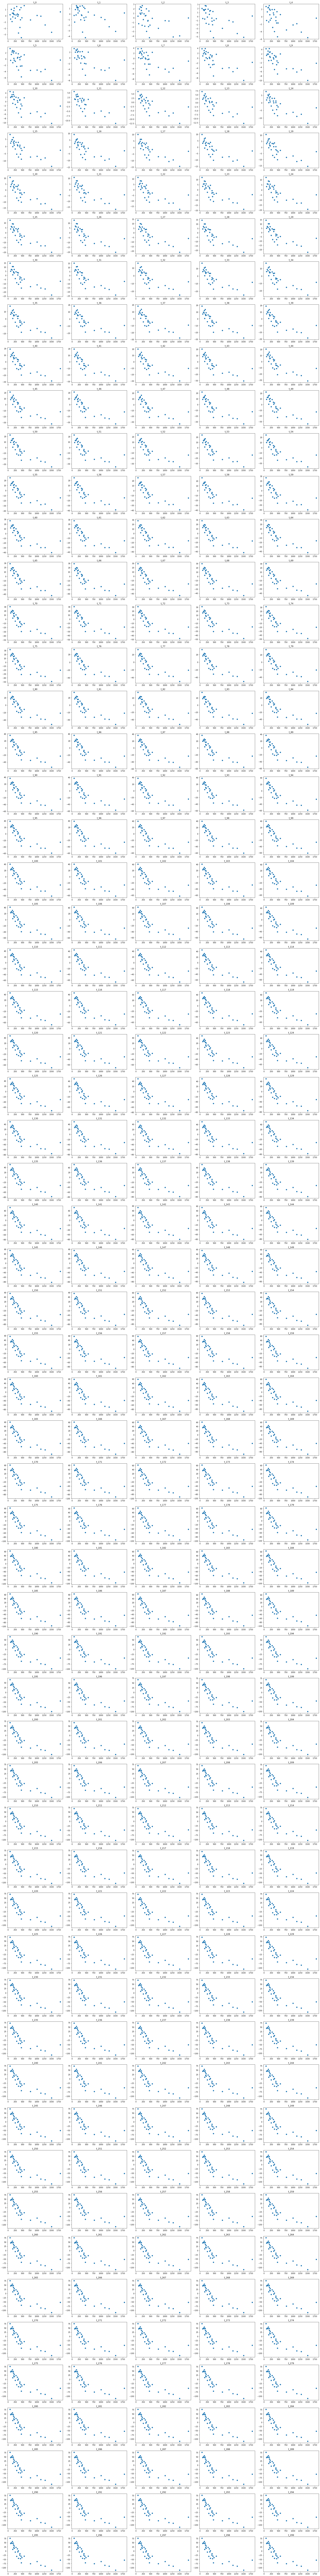

In [171]:
T = 300
X_T = [np.random.multivariate_normal(np.zeros(31), np.identity(31)) for _ in range(4)]

a, b = denoise(model_bigEpoch, X_T[0])

plt.figure(figsize= (25, 200))
for t in range(300):
    plt.subplot(60, 5, t + 1)
    plt.title("t_" + str(t))
    plt.scatter(filter_wls, b[t])
plt.tight_layout()
plt.show()

Plots

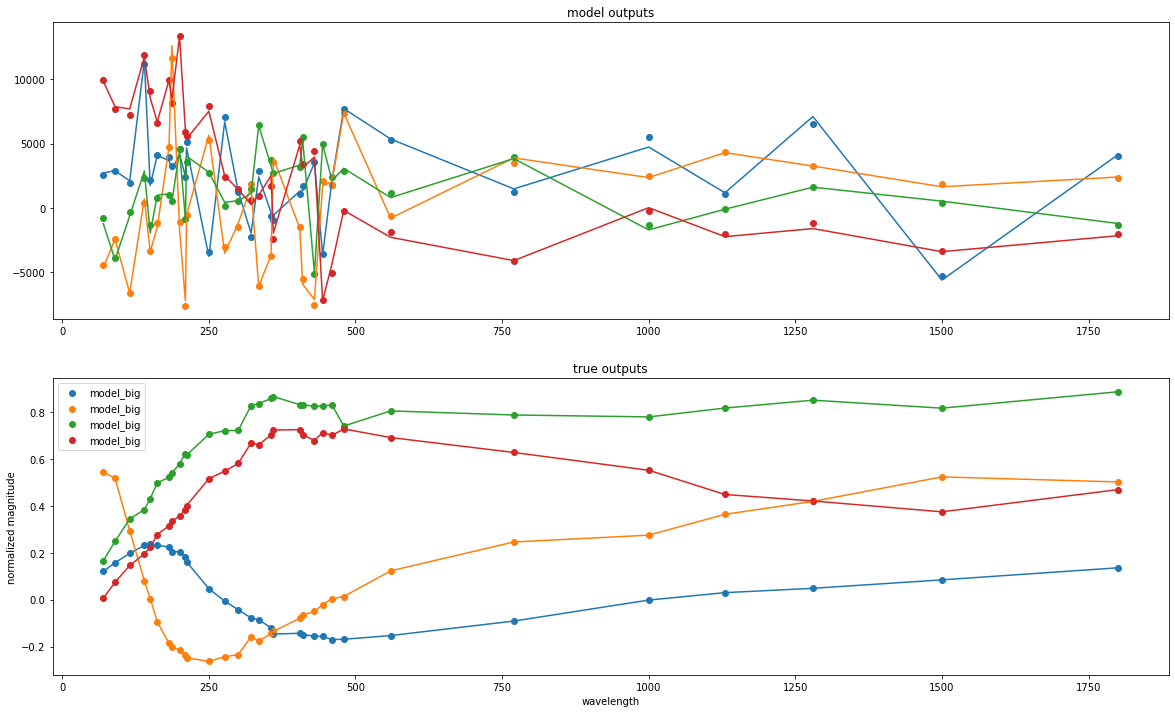

In [115]:
device = "cpu"
X_T = [np.random.multivariate_normal(np.zeros(31), np.identity(31)) for _ in range(4)]

plt.figure(figsize= (20, 12))

for i in range(4):
    plt.subplot(2, 1, 1)
    plt.title('model outputs')
    plt.scatter(filter_wls, denoise(model_bigEpoch, X_T[i]).cpu().detach(), label = "model_big")
    plt.plot(filter_wls, (denoise(model_bigEpoch, X_T[i]).cpu().detach()).squeeze())
    plt.subplot(2, 1, 2)
    plt.title('true outputs')
    r = np.random.randint(0, 100)
    plt.scatter(filter_wls, X_normalized[r], label = "model_big")
    plt.plot(filter_wls, X_normalized[r])

plt.ylabel("normalized magnitude")
#plt.ylim(-2, 2)
plt.xlabel("wavelength")
plt.legend()

In [113]:
model_big = BigUNet().double().to(device)
model_big.load_state_dict(torch.load('../runs/model_param_model_big.pt'))

model_medBig = MedBigUNet().double().to(device)
model_medBig.load_state_dict(torch.load('../runs/model_param_model_medBig.pt'))

model_medium = MediumUNet().double().to(device)
model_medium.load_state_dict(torch.load('../runs/model_param_model_medium.pt'))

model_small = SmallUNet().double().to(device)
model_small.load_state_dict(torch.load('../runs/model_param_model_small.pt'))

modelList = [model_big, model_medBig, model_medium, model_small]
modelNames = ["model_big", "model_medBig", "model_medium", "model_small"]

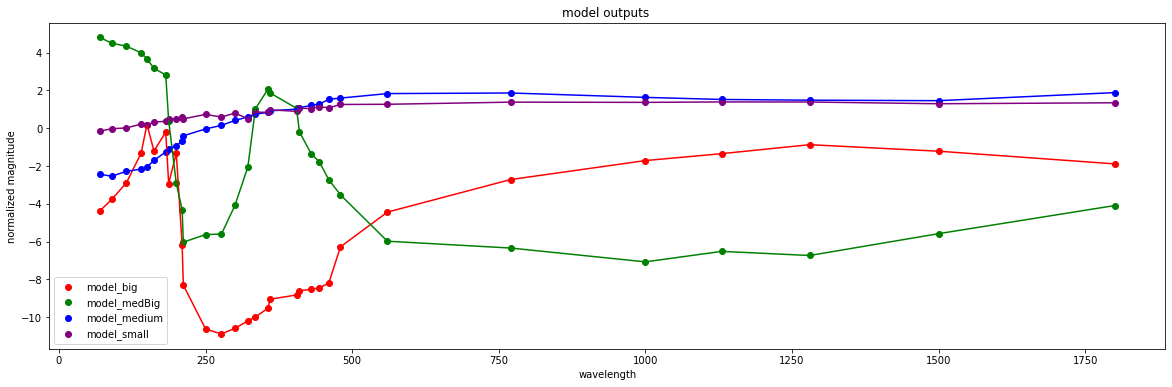

In [116]:
X_T = [np.random.multivariate_normal(np.zeros(31), np.identity(31)) for _ in range(2)]


plt.figure(figsize= (20, 6))
color = ["red", "green", "blue", "purple"]
for i in range(4):
    plt.subplot(1, 1, 1)
    plt.title('model outputs ')
    for j in range(1):
        plt.scatter(filter_wls, denoise(modelList[i], X_T[j], T = 100).cpu().detach(), label = modelNames[i], color = color[i])
        plt.plot(filter_wls, denoise(modelList[i], X_T[j], T = 100).cpu().detach().squeeze(), color = color[i])
plt.ylabel("normalized magnitude")
#plt.ylim(-2, 2)
plt.xlabel("wavelength")
plt.legend()

#plt.savefig('data/foo.png')

In [61]:
torch.cat([a, b], dim =2)

tensor([[[0.2627, 0.3423, 0.5273, 0.0132, 0.6225, 0.1469, 0.3152, 0.8331,
          0.9281, 0.9977, 0.1056, 0.8544, 0.8214, 0.6479, 0.0035, 0.4529,
          0.1141, 0.2200, 0.9370, 0.9805, 0.2026, 0.9675, 0.0452, 0.7937,
          0.8839, 0.8853, 0.7643, 0.1215, 0.6077, 0.0728, 0.9927, 0.2989,
          0.0200, 0.8774, 0.2481, 0.0949, 0.8746, 0.3038, 0.8514, 0.7330,
          0.4749, 0.6460, 0.8380, 0.3986, 0.7926, 0.8653, 0.7218, 0.9125,
          0.9866, 0.6227, 0.0565, 0.9312, 0.3466, 0.1134, 0.1091, 0.2718,
          0.5052, 0.2798, 0.4689, 0.2172, 0.3623, 0.5519]]])

In [63]:
class TimeEmbedding(nn.Module):
    def __init__(self, n_channels: int):
        super().__init__()
        self.n_channels = n_channels
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        half_dim = self.n_channels // 8
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        emb = self.relu(self.lin1(emb))
        emb = self.lin2(emb)

        return emb


In [64]:
tEmb = TimeEmbedding(10)

In [65]:
tEmb

TimeEmbedding(
  (lin1): Linear(in_features=2, out_features=10, bias=True)
  (relu): ReLU()
  (lin2): Linear(in_features=10, out_features=10, bias=True)
)

Evaluation

In [ ]:
############################################################################
# evaluation
############################################################################


In [179]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(192, 192)
        self.fc2 = nn.Linear(192, 4)  
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x2 = self.fc1(x)
        x = self.relu(x2)
        x = self.fc2(x)

        return x2, x


In [213]:
def train_modelCNN(model, n = len(X_normalized), batch_size = 256, EPOCHS = 50):
    #loss
    loss_fn = nn.MSELoss()
    #optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    #loss data
    running_loss_arr = []

    #training
    model.train(True)
    with open("../runs2/foo.txt", "w") as f:
        f.write("start \n")
    for epoch in range(EPOCHS):
        with open("../runs2/foo.txt", "a") as f:
            f.write("epoch: " + str(epoch) + "\n")
        # generate data_loader
        train_dataloader = DataLoader(MyDataset({"X": X_normalized[:n], "y": y_normalized[:n]}), batch_size=batch_size, shuffle=True)
        
        print('EPOCH ', epoch, ":")
        
        running_loss = 0
        last_loss = 0

        for i, data in enumerate(train_dataloader):
            X_t = data['X']
            ys = data['y']
            X_t = X_t.clone().detach().unsqueeze(1).double()
            ys = ys.clone().detach().unsqueeze(1).double()
            # Zero gradients for every batch
            optimizer.zero_grad()

            # Make predictions for this batch
            _, outputs = model(X_t)
            
            # Compute the loss and its gradients
            loss = loss_fn(outputs, ys.squeeze())

            loss.backward()

            # Adjust learning weights
            optimizer.step()

            # Gather data
            running_loss += loss.item()
            if (i+1) % 100 == 0:
                last_loss = running_loss / 100 # loss per batch
                tb_x = epoch * len(train_dataloader) + i + 1
                running_loss_arr.append([tb_x, last_loss])
                running_loss = 0.
                with open("../runs2/foo.txt", "a") as f:
                    f.write(str(last_loss) + "\n")
        scheduler.step()

        print('LOSS train: ', running_loss_arr[-1])

    model.train(False)
    return np.array(running_loss_arr)


In [214]:
# train all models
model_CNN = CNN().double().to(device)
n = 1024000
batch_size = 64
epochs = 1
print("#####################################")
print("n: ", n)
print("batch_size: ", batch_size)
print("Epochs: ", epochs)
#print("model: ", model)

running_loss_arr = train_modelCNN(model_CNN, n = n, batch_size = batch_size, EPOCHS = epochs)

torch.save(model_CNN.state_dict(), '../runs2/model_param_CNN.pt')
df_loss = pd.DataFrame({"time": running_loss_arr.reshape(-1, 2).transpose()[0], "loss": running_loss_arr.reshape(-1, 2).transpose()[1]})
df_loss.to_csv('../runs2/losses_CNN.csv', index = False)
print("#####################################")

#####################################
n:  1024000
batch_size:  64
Epochs:  1
EPOCH  0 :
LOSS train:  [16000, 0.2839793212759066]
#####################################


In [286]:
def calculate_fid(real_embeddings, generated_embeddings):
    # calculate mean and covariance statistics
    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings,  rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


In [287]:
model_CNN = CNN().double().to(device)
model_CNN.load_state_dict(torch.load('../runs2/model_param_CNN.pt'))



<All keys matched successfully>

In [288]:
X_T = [np.random.multivariate_normal(np.zeros(31), np.identity(31)) for _ in range(4)]
X0 = X_normalized[0].astype('float64')

bs = 10

model_emb = np.array([])
for i in range(bs):

    out_model, _ = denoise(model_Unet, np.random.multivariate_normal(np.zeros(31), np.identity(31)))
    lay_model, _ = model_CNN(out_model.unsqueeze(0).unsqueeze(0))
    model_emb = np.append(model_emb, lay_model.squeeze().detach().numpy())
model_emb = model_emb.reshape(bs, 192)


out_true = X_normalized[:bs].astype('float64')
true_emb, _ = model_CNN(torch.tensor(out_true).unsqueeze(1))
true_emb = true_emb.squeeze().detach().numpy()

print(model_emb.shape)
print(true_emb.shape)


calculate_fid(true_emb, model_emb)



(10, 192)
(10, 192)


75239.79170082018

In [285]:
np.sum(true_emb - model_emb , axis = (0, 1))

25914.19755027673

In [ ]:
np.cov(np.arange(20), np.ones(20), rowvar = False)

array([[35.,  0.],
       [ 0.,  0.]])